In [1]:
%pylab inline
import pandas as pd

import seaborn as sns
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train_variant = pd.read_csv("training_variants").set_index("ID")
df_train_text = pd.read_csv("training_text", delimiter = "\|\|", skiprows=1, names=['ID', 'Text'], engine="python").set_index('ID')

df_test_variant = pd.read_csv("test_variants").set_index("ID")
df_test_text = pd.read_csv("test_text", delimiter = "\|\|", skiprows = 1, names=["ID", "Text"], engine="python").set_index("ID")

In [3]:
df_train = pd.concat([df_train_variant, df_train_text ], axis=1)
df_test = pd.concat([df_test_variant, df_test_text], axis=1)

In [4]:
display(df_train.head())
display(df_test.head())

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


,Gene,Variation,Text
ID,,,
0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [5]:
print(df_train["Gene"].value_counts()[:10])
print(df_train["Class"].value_counts())

print(df_test["Gene"].value_counts()[:10])

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
Name: Gene, dtype: int64
7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64
F8       134
CFTR      57
F9        54
G6PD      46
GBA       39
PAH       38
AR        38
CASR      37
ARSA      30
BRCA1     29
Name: Gene, dtype: int64


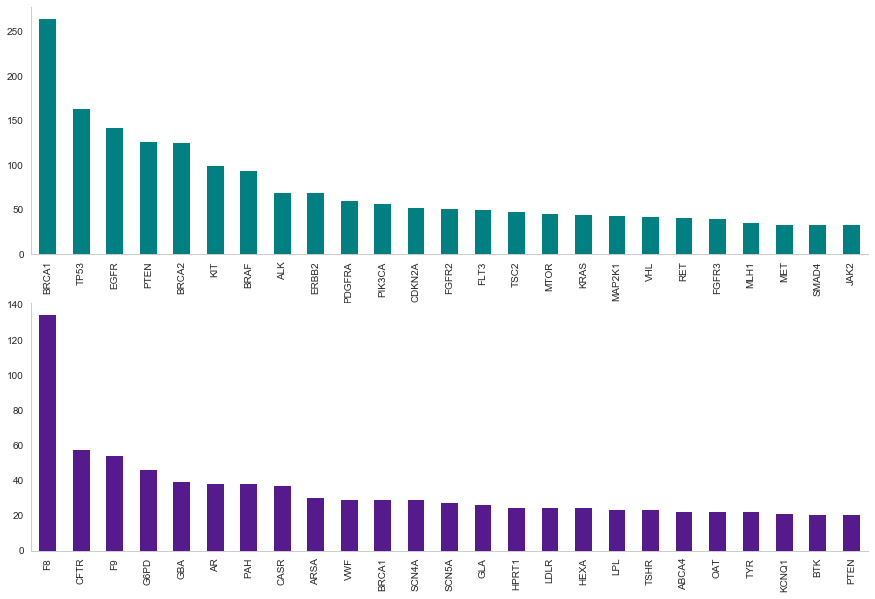

In [6]:
most_common_train = df_train["Gene"].value_counts()[:25] 
most_common_genes = most_common_train.index
df_train_most_common = df_train[df_train["Gene"].isin(most_common_genes)]
df_train_most_common_counts = df_train_most_common["Gene"].value_counts()

most_common_test = df_test["Gene"].value_counts()[:25] 
most_common_genes = most_common_test.index
df_test_most_common = df_test[df_test["Gene"].isin(most_common_genes)]
df_test_most_common_counts = df_test_most_common["Gene"].value_counts()

plt.figure(figsize=(15,10))
ax = plt.subplot(211)
df_train_most_common_counts.plot("bar", color="teal")
plt.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax = plt.subplot(212)
df_test_most_common_counts.plot("bar", color="#551a8b")
plt.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


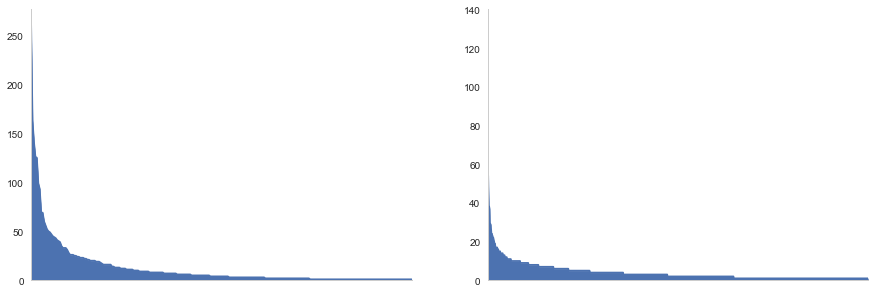

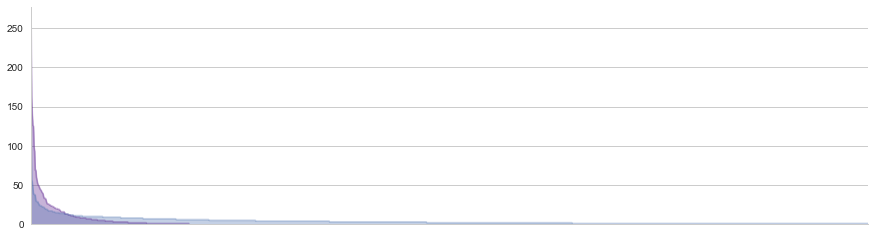

In [40]:
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
df_train["Gene"].value_counts().plot("area")
plt.grid(False)
ax.get_xaxis().set_ticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax = plt.subplot(122)
df_test["Gene"].value_counts().plot("area")
plt.grid(False)
ax.get_xaxis().set_ticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.figure(figsize=(15,4))
ax = plt.subplot()
df_train["Gene"].value_counts().plot("area", alpha=0.33, color="#551a8b")
df_test["Gene"].value_counts().plot("area", alpha=0.33)
ax.get_xaxis().set_ticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

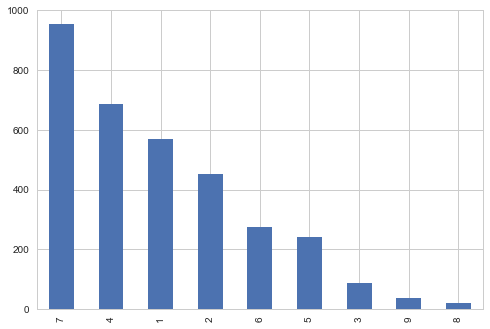

In [8]:
df_train["Class"].value_counts().plot(kind="bar", color = "#551a8b")

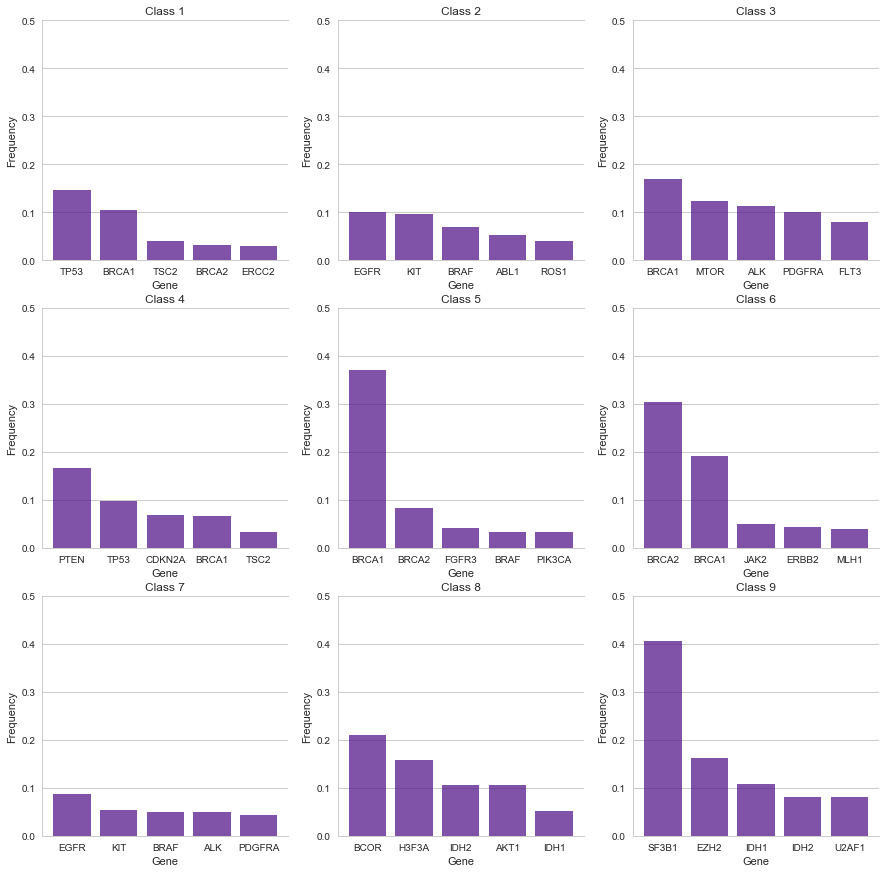

In [42]:
df_train_grouped = df_train.groupby("Class")


plt.figure(figsize = (15,15))
for i,group in enumerate(df_train_grouped):
    most_frequent = group[1]["Gene"].value_counts()[:5]
    total = group[1]["Gene"].value_counts().sum()
    fraction = most_frequent/total
    ax = plt.subplot(3,3,i+1)
    plt.title("Class {}".format(i+1))
    plt.xticks(range(5), group[1]["Gene"].value_counts()[:5].index)
    plt.xlabel("Gene")
    plt.ylabel("Frequency")
    plt.ylim(0, 0.5)
    plt.grid(axis='x')
    ax.spines["right"].set_visible(False)
    fig = plt.bar(range(5), most_frequent/total, color="#551a8b", alpha=0.75)

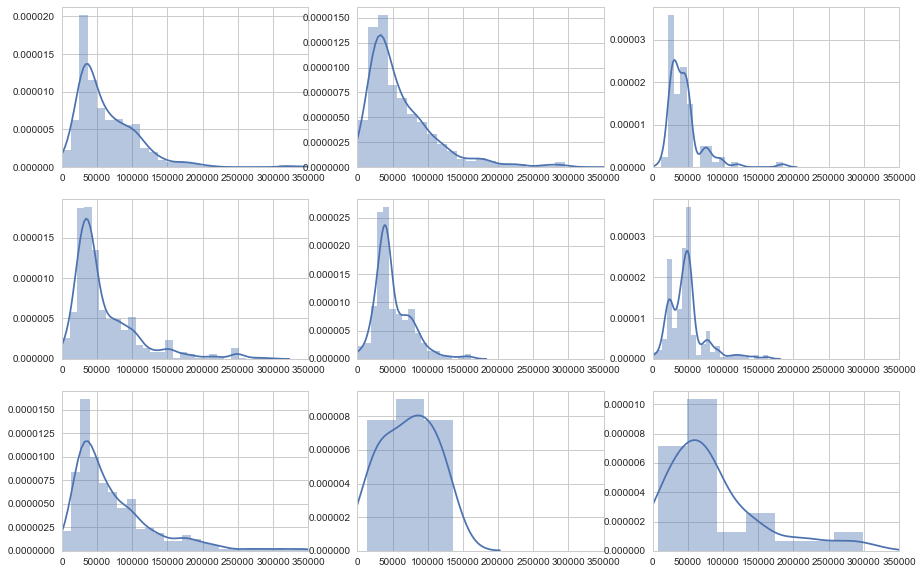

In [71]:
plt.figure(figsize=(15,10))
for i, group in enumerate(df_train_grouped):
    ax = plt.subplot(3,3,i+1)
    plt.xlim(0,350000)
    length = []
    for text in group[1]["Text"]:
        length.append(len(text))
    #plt.hist(length,bins=50,color="purple", alpha=0.66)
    sns.distplot(length)
        